# Névegyezések vizsgálata

In [2]:
import pandas
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from ipydatagrid import DataGrid
import ipywidgets as widgets
from ipywidgets import interactive
from ipywidgets import interact


records = pandas.read_excel('sources/zipserbuch.xlsx', sheet_name='1620 vs 1667')

records.head(5)

,lőcsei családok 1620,lőcsei családok 1667
0,Abscheimen,Aaron
1,Abzieher,Abrachamides
2,Audrich,Achband
3,Bank,Adam
4,Bardt,Adami


In [3]:
citizens = pandas.read_excel('sources/zipserbuch.xlsx', sheet_name='személyek')
citizens.head()

,id,név,születési hely,névváltozat,foglalkozás,életrajzi hivatkozás,rövid leírás,RMNy (alkalmi)
0,1001,[szervezet] a besztercebányai evangélikus isko...,NaN,NaN,vizsga,NaN,A tételeket 1642 májusában vitatták meg a besz...,1934
1,1002,[szervezet] a lőcsei evangélikus gimnázium elő...,NaN,NaN,program,NaN,Meghívó a lőcsei evangélikus gimnázium hallgat...,2223
2,1003,[szervezet] a lőcsei evangélikus gimnázium ünn...,NaN,NaN,program,NaN,A lőcsei evangélikus gimnázium 1666. január 30...,3295
3,1004,[szervezet] a lőcsei evangélikus gimnázium viz...,NaN,NaN,vizsga,NaN,A nyomtatvány a lőcsei evangélikus gimnázium 1...,3296
4,1005,[szervezet] a lőcsei evangélikus gimnázium viz...,NaN,NaN,vizsga,NaN,1646. szeptember 9. A tételeket szeptember 25-...,2147


Az alábbiakban két külön listába rendezem az 1620. évi és az 1667. évi lőcsei birtokösszeírások névsorát, majd a listákat metszem a Python beépített halmazkezelő függvényével. Ezekből az adatokból, a listák méretét megadva 2-elemű Venn-diagramot tudunk készíteni a matplotlib-re épülő matplotlib-venn könyvtár segítségével. A diagram segítségével információt kaphatunk a népesség és a birtokviszonyok változásáról a két összeírás között eltelt időben.

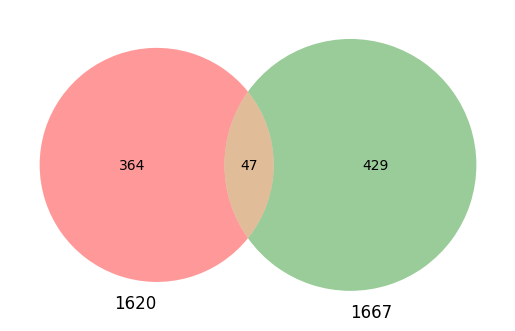

In [5]:
list_1620 = records['lőcsei családok 1620'].dropna().values.tolist()
list_1667 = records['lőcsei családok 1667'].dropna().values.tolist()
list_intersection = list(set(list_1620).intersection(list_1667))


venn2(subsets = (len(list_1620), len(list_1667), len(list_intersection)), set_labels = ('1620', '1667'))
plt.show()

A következőkben szeretnénk meghatározni, hogy a birtokösszeírásokban szereplő családnevek közül hány fordul elő az alkalmi nyomtatványokban is. Ehhez egy új adatstruktúrát határozunk meg, amelyben a két összeírásban szereplő összes lőcsei családnév szerepel. Ezután importáljuk az alkalmi nyomtatványokban szereplő családneveket tartalmazó táblát is, majd összevetést végzünk az egyezésekről. Az így létrehozott táblázat első oszlopában szerepelnek a családnevek a birtokösszeírásokból, majd láthatjuk, hogy a név megjelenik-e az alkalmi nyomtatványok listájában. Ha az azonosság kétséges, százalékos egyezést is láthatunk.

In [36]:
df = pandas.read_excel('sources/zipserbuch.xlsx', sheet_name='alkalmi vezetéknevek', header=None)
names = df[0].to_list()

from fuzzywuzzy import fuzz
TRESHOLD=80

def find_in_names(name):
    for n in names:
        if n==name:
            return 'igaz'
        elif fuzz.ratio(name,n) > TRESHOLD:
            return str(fuzz.ratio(name,n)) + '%-os egyezés: ' + n
    return 'hamis'


list_of_names = []
for item in list_1620:
    record = {}
    record['name'] = item
    in_names = find_in_names(item)
    record['alkalmi listán'] = in_names
    if in_names != 'igaz' and in_names != 'hamis':
        record['alkalmi listán'] = 'kétséges'
        record['megjegyzés'] = in_names

        
    if item in list_intersection:
        record['év'] = 'mindkettő'
    else:
        record['év'] = 'csak 1620'
    list_of_names.append(record)
    
for item in list_1667:
    if item in list_intersection:
        continue
    record = {}
    record['name'] = item
    in_names = find_in_names(item)
    record['alkalmi listán'] = in_names
    if in_names != 'igaz' and in_names != 'hamis':
        record['alkalmi listán'] = 'kétséges'
        record['megjegyzés'] = in_names
    record['év'] = 'csak 1667'
    list_of_names.append(record)


df = pandas.DataFrame.from_records(list_of_names)

from IPython.display import display, HTML
display(
    HTML(
        "<div style='height: 300px; overflow: auto; width: fit-content'>" +
        df.to_html() +
        "</div>"
    )
)

,name,alkalmi listán,év,megjegyzés
0,Abscheimen,hamis,csak 1620,NaN
1,Abzieher,hamis,csak 1620,NaN
2,Audrich,hamis,csak 1620,NaN
3,Bank,hamis,csak 1620,NaN
4,Bardt,hamis,csak 1620,NaN
5,Bartsch,kétséges,mindkettő,83%-os egyezés: Barth
6,Beck,hamis,mindkettő,NaN
7,Beischitzer,hamis,csak 1620,NaN
8,Beitler,hamis,csak 1620,NaN
9,Bellersheim,hamis,csak 1620,NaN


In [38]:
percentage = df['alkalmi listán'].value_counts(normalize=True).mul(100).to_frame(name='százalék')
percentage

,százalék
hamis,79.597315
kétséges,13.557047
igaz,6.845638
